### VENDOR RANKING : PROTOTYPE

#### I. Model Training And Evaluation

#### [1]: Data Generation / Preparation : Historic Data

In [1]:
# Import the libraries.
import numpy as np
import pandas as pd
import random
import warnings
warnings.filterwarnings("ignore")
from prettytable import PrettyTable

# List containing dataframes.
lstDataFrames = []

def generateHistoricData(monthYear):
    """
    Function to generate the data based on time periods.
    """
    # Number of rows to generate.
    rowNum = 100
    # Define the columns.
    columns =['ProductType','VendorName','ProductPrice']
    # Define the indexes
    index   = np.arange(rowNum)
    # build the vendor data.
    producttype = ['P01' for i in np.arange(rowNum)]
    vendorcode = ['V0'+ str(i+1) for i in np.arange(rowNum)]
    productprice = [round(random.uniform(495,505),2) for i in np.arange(rowNum)]
    # combine the product,vendor,price
    data = zip(producttype,vendorcode,productprice)
    # create the dataframe with the above data.
    dfVendor = pd.DataFrame(index=index,columns = columns,data=data)
    # set the "Is_Selected" flag.
    dfVendor['Is_Selected'] = 0
    # Add a timeperiod column.
    dfVendor['MonthYear'] = monthYear
    # Get the best price, and set the Is_Selected flag.
    dfVendorMinPrice = dfVendor.sort_values(by=['ProductPrice'],ascending=True).head(1)
    dfVendorMinPrice['Is_Selected'] = 1
    dfVendor['Is_Selected'].loc[dfVendorMinPrice.index] = dfVendorMinPrice['Is_Selected']
    del dfVendorMinPrice

    # add the dataframe to a list.
    lstDataFrames.append(dfVendor)
 # function scope ends here.


#List of timeperiods for which data needs to be generated.
lstTimePeriod = ['201201','201202','201203','201204','201205','201206','201207','201208','201209','201210','201211','201212',
                 '201301','201302','201303','201304','201305','201306','201307','201308','201309','201310','201311','201312',
                 '201401','201402','201403','201404','201405','201406','201407','201408','201409','201410','201411','201412',
                 '201501','201502','201503','201504','201505','201506','201507','201508','201509','201510','201511','201512',
                 '201601','201602','201603','201604','201605','201606','201607','201608','201609','201610','201611','201612',
                 '201701','201702','201703','201704','201705','201706','201707','201708','201709','201710','201711','201712',
                 '201801','201802','201803','201804','201805','201806','201807','201808','201809','201810','201811','201812',
                 ]

# call the function to generate data.
for mnyr in lstTimePeriod:
    generateHistoricData(mnyr)

# concatenate all the dataframes based on timeperiods into a single dataframe.
dfVendorFinal = pd.concat(lstDataFrames,ignore_index=True)

In [2]:
#dfVendorFinal.describe()
dfVendorFinal.tail()

,ProductType,VendorName,ProductPrice,Is_Selected,MonthYear
8395,P01,V096,499.76,0,201812
8396,P01,V097,495.44,0,201812
8397,P01,V098,502.66,0,201812
8398,P01,V099,501.74,0,201812
8399,P01,V0100,503.21,0,201812


In [3]:
# Split the input and output features.
# Input
X_Input  = dfVendorFinal[['ProductPrice']]
# Output
Y_Output = dfVendorFinal[['Is_Selected']] 

#### [2]: Intantiate the class.

In [4]:
# Instantiate and Consume the class.
from classMLModelingPipeline import *
# Import json module.  
import json
import os
cwd = str(os.getcwd()) + "\\"
cwd = cwd.replace("\\","\\\\")


#===== Scope within the py file ==================================================
# Path of the App config file. This will be hard coded.
appConfigFile = cwd + 'AppConfig.txt'
# Class name.
s_classApplication = 'classMLModelingPipeline'
#=================================================================================
# Error description.
error_desc = ''

#===== Get App config details =======================================================
def GetAppConfig():
    #==== This variable will have global scope within this .py file =================
    global error_desc
    error_desc = 'No error'
    #===============================================================================
    # Open and read the App Configuration using json.
    with open(appConfigFile) as json_file:
        # Load the App config details.
        data = json.load(json_file)
        # For each entry in json, extract App config parameters.
        for p in data['AppConfig']:
            appConfig = modMLModelingPipeline   (   p['Id'],
                                                    p['Name'],
                                                    p['Source'],
                                                    p['Output'],
                                                    p['TrainedModel'],
                                                    p['ExecutionLog'],
                                                    p['ExecutionLogFileName'],
                                                    p['Archive']
                                                 )
    return appConfig
#=====================================================================================
# Call the below code, when the python file is run.
#if __name__ == "__main__":
if 1==1:
    # Call function to instantiate the class.
    applConfig = GetAppConfig()
    # Create Application directories.
    _ = applConfig.CreateAppDirectories()

#### [2]: Time Based Splitting : Training, Cross-valdation and Test

In [5]:
# Get the total row count.
total_rowCount = len(X_Input)
# Is time based splitting of dataset required.
IsTimeBasedSplitting = 1
# Data split ratio for train, cv and test set.
Training_split_ratio = 0.6
Crossvalidation_split_ratio = 0.2
Test_split_ratio = 0.2

# Call the method to split the data.
X_train,X_cv,X_test,Y_train,Y_cv,Y_test = applConfig.split_data(dfX = X_Input,
                                                                dfY = Y_Output,
                                                                total_rowCount = total_rowCount,
                                                                IsTimeBasedSplitting = IsTimeBasedSplitting,
                                                                Training_split_ratio = Training_split_ratio,
                                                                Crossvalidation_split_ratio = Crossvalidation_split_ratio,
                                                                Test_split_ratio = Test_split_ratio)


#### [3]: Standardize the Data :

In [6]:
IsNormalize = 0
normalizer,X_train_stdzd,X_cv_stdzd,X_test_stdzd,Y_train_ravel,Y_cv_ravel,Y_test_ravel = applConfig.standardize_data(IsNormalize=IsNormalize)
# Pickle the standardizer.
pklTrainedStandardizer = applConfig.PickleTrainedObject('TN',normalizer)
print(pklTrainedStandardizer)

C:\Users\HP\DevEnv\Projects\VendorSelection\VendorRanking_POC\TrainedModel\trainedStandardizer_1001


#### [4]: Hyper-parameter Tuning :

In [7]:
gridResults,bestScore,optimal_HyperParameter = applConfig.GetModelHyperParameter()

#### [5]: Model training.

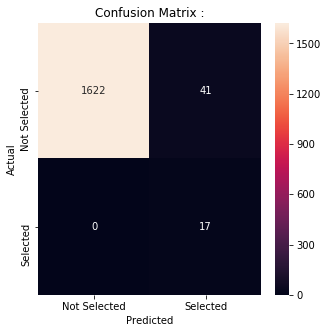

In [8]:
# Get the trained model with the optimal hyperparameter.
lr_optimal = applConfig.GetTrainedModel(optimal_HyperParameter)

# Get the calibrated model.
calibratedCCV = applConfig.GetCalibratedModel()

# Get the predictions from the test set.
X_test_stdzd, Y_pred_test = applConfig.GetPredictions()

# Get the calibrated predictions from the test set.
X_test_stdzd, Y_pred_calib = applConfig.GetCalibratedPredictions()

# Get the model confusion matrix
plt , confmat, tn, fp, fn, tp = applConfig.GetModelConfusionMatrixForBinaryClass()

#### [6] : Model Evaluation.

Actual Negative Class:  1663
Actual Positive Class:  17


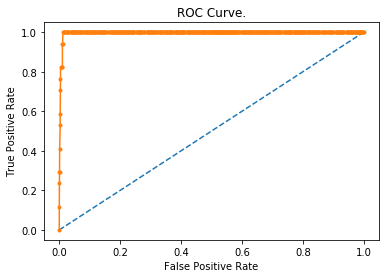

ROC AUC Score: 0.996657352056878


In [9]:
# Get actual class distribution.
negative_class,positive_class = applConfig.GetActualClassDistributionForBinaryClass()
print("Actual Negative Class: ",negative_class)
print("Actual Positive Class: ",positive_class)

# Get the ROC value.
import matplotlib.pyplot as plt1
%matplotlib inline

plt1,roc_score = applConfig.GetModelROCForBinaryClass()
plt1.show()

print("ROC AUC Score:",roc_score)


#### [7]: Write Model Metrics To Log.

In [10]:
# Generate Model trace.
# Set the model trace parameters.
modelTrace = "[ModelHyperParameters]:[" + str(gridResults) + "];"
modelTrace = modelTrace + "[ModelOptimalHyperParameter]:[" + str(optimal_HyperParameter) + "];"
modelTrace = modelTrace + "[Class_Labels]:[NotSelected|Selected];"
modelTrace = modelTrace + "[ModelConfusionMatrix]:[" + str(confmat) + "];"
modelTrace = modelTrace + "[ModelROC_AUC]:[" + str(roc_score) + "];"
modelTrace = modelTrace + "[Actual_ClassDistribution]:[" + str(negative_class) + "|" + str(positive_class) + "];"

# Call method to write the model trace to log.
applConfig.WriteToActivityLog(classApplication  = s_classApplication,
                              classMethod       = 'General',
                              statusType        = 'Success',
                              statusDescription = modelTrace)

#### [8]: Pickle The Trained Model.

In [16]:
# Pickle the trained Model.
pklTrainedModel = applConfig.PickleTrainedObject('TM',lr_optimal)
print(pklTrainedModel)
pklTrainedCalibratedModel = applConfig.PickleTrainedObject('TCM',calibratedCCV)
print(pklTrainedCalibratedModel)

C:\Users\HP\DevEnv\Projects\VendorSelection\VendorRanking_POC\TrainedModel\trainedModel_1001
C:\Users\HP\DevEnv\Projects\VendorSelection\VendorRanking_POC\TrainedModel\trainedCalibratedModel_1001


#### II. Prediction : On New Query Point / Data

#### [8]: Data Preparation : New Unseen Point

In [17]:
# Import the libraries.
import numpy as np
import pandas as pd
import random
import warnings
warnings.filterwarnings("ignore")
from prettytable import PrettyTable

# List containing dataframes.
lstDataFramesCurrent = []

def generateCurrentData(monthYear):
    """
    Function to generate the current data.
    """
    # Number of rows to generate.
    rowNum = 100
    # Define the columns.
    columns =['ProductType','VendorName','ProductPrice']
    # Define the indexes
    index   = np.arange(rowNum)
    # build the vendor data.
    producttype = ['P01' for i in np.arange(rowNum)]
    vendorcode = ['V0'+ str(i+1) for i in np.arange(rowNum)]
    productprice = [round(random.uniform(495,505),2) for i in np.arange(rowNum)]
    # combine the product,vendor,price
    data = zip(producttype,vendorcode,productprice)
    # create the dataframe with the above data.
    dfVendorNew = pd.DataFrame(index=index,columns = columns,data=data)
    # Add a timeperiod column.
    dfVendorNew['MonthYear'] = monthYear

    # add the dataframe to a list.
    lstDataFramesCurrent.append(dfVendorNew)
 # function scope ends here.


#List of timeperiods for which data needs to be generated.
lstTimePeriodCurrent = ['201901']

# call the function to generate data.
for mnyr in lstTimePeriodCurrent:
    generateCurrentData(mnyr)

# concatenate the current timeperiod into a single dataframe.
dfVendorFinalCurrent = pd.concat(lstDataFramesCurrent,ignore_index=True)

# Generate the unlabelled data for modelling with feature inclusion.
X_unlabelled = dfVendorFinalCurrent[['ProductPrice']][dfVendorFinalCurrent['MonthYear'].isin(['201901'])]

# Standardize the unlabelled data.
# Load the standardizer from the pickle.
scaler = applConfig.GetTrainedObjectFromPickle('TN')
X_unlabelled_stdzd  = scaler.transform(X_unlabelled)


In [18]:
X_unlabelled.head()

,ProductPrice
0,502.95
1,499.00
2,495.90
3,503.86
4,503.32


#### [9]: Model prediction on unlabelled data.

In [19]:
# Load the trained model from the pickle.
lr_optimal = applConfig.GetTrainedObjectFromPickle('TM')
calibratedCCV = applConfig.GetTrainedObjectFromPickle('TCM')
# predict,response from the Logistic Regression model.
Y_pred_unlabelled = lr_optimal.predict(X_unlabelled_stdzd)  
# predict class probabilities on the unlabelledset.
Y_pred_unlabelled_calib = calibratedCCV.predict_proba(X_unlabelled_stdzd)[:, 1]   

#Update the dataframe with the predicted values and probabilities.
dfVendorFinalCurrent['Is_Selected_Predicted'] = Y_pred_unlabelled
dfVendorFinalCurrent['Likehood_Score'] = Y_pred_unlabelled_calib


In [20]:
dfVendorFinalCurrent[dfVendorFinalCurrent['Is_Selected_Predicted'] == 1]

,ProductType,VendorName,ProductPrice,MonthYear,Is_Selected_Predicted,Likehood_Score
31,P01,V032,495.23,201901,1,0.123842
43,P01,V044,495.06,201901,1,0.161565
54,P01,V055,495.28,201901,1,0.114285
69,P01,V070,495.19,201901,1,0.131974
77,P01,V078,495.12,201901,1,0.147292


In [21]:
dfVendorFinalCurrent.sort_values(by=['ProductPrice'],ascending=True).head(10)

,ProductType,VendorName,ProductPrice,MonthYear,Is_Selected_Predicted,Likehood_Score
43,P01,V044,495.06,201901,1,0.161565
77,P01,V078,495.12,201901,1,0.147292
69,P01,V070,495.19,201901,1,0.131974
31,P01,V032,495.23,201901,1,0.123842
54,P01,V055,495.28,201901,1,0.114285
57,P01,V058,495.45,201901,0,0.086463
12,P01,V013,495.47,201901,0,0.083627
28,P01,V029,495.52,201901,0,0.076904
84,P01,V085,495.57,201901,0,0.070680
66,P01,V067,495.58,201901,0,0.069492


#### Import class from different directory.

In [84]:
# Check, if path exists in system path,else add.
if 'C:\\Users\\HP\\DevEnv\\Projects\\Test' in os.environ:
    sys.path.append('C:\\Users\\HP\\DevEnv\\Projects\\Test')

# Instantiate and Consume the class.
from classGeneral import *
# Import json module.  
import json
# Open and read the App Configuration using json.
with open('C:\\Users\\HP\\DevEnv\\Projects\\Test\\AppConfig.txt') as json_file:
    # Load the App config details.
    data = json.load(json_file)
    # For each entry in json, extract App config parameters.
    for p in data['AppConfig']:
        applConfig = ApplicationConfiguration(  p['Id'],
                                                p['Name'],
                                                p['Source'],
                                                p['Output'],
                                                p['TrainedModel'],
                                                p['ExecutionLog'],
                                                p['ExecutionLogFileName'],
                                                p['Archive']
                                              )
#===== Write to activity log ============================================================
s_classApplication  = 'classGeneral'
s_classMethod       = 'CreateAppDirectories'
s_statusType        = 'Success'
#s_statusDescription = 'Successfull write operation.'
s_statusDescription = str(conf_mat)
applConfig.WriteToActivityLog(s_classApplication,
                              s_classMethod,
                              s_statusType,
                              s_statusDescription
                             )